In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import torch
from torch import nn
mse = nn.MSELoss()


np.random.seed(42)

In [51]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, p=0, q=0) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(q,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [3]:
ma2 = np.array([1,0,0])
ar2 = np.array([1, -0.33, -0.50])
AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

<Axes: >

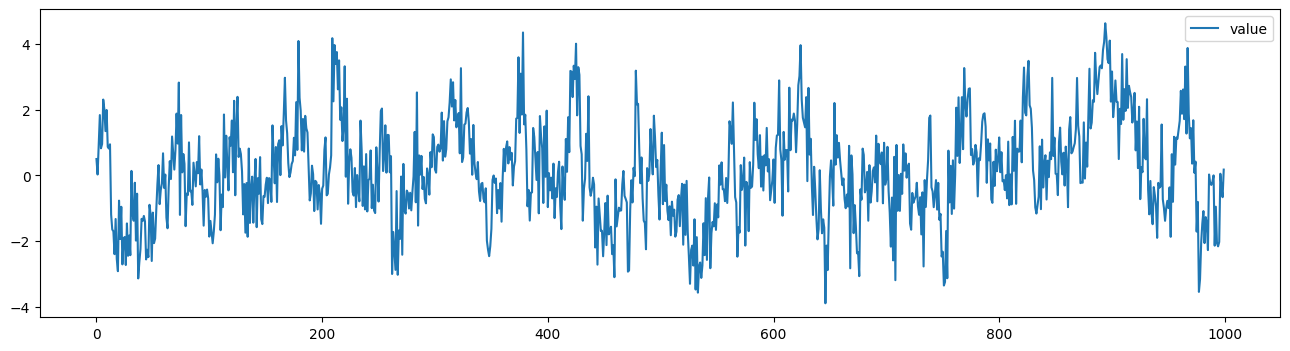

In [4]:
df = pd.DataFrame({'value': AR2_process})
df.plot( figsize=(16,4),  layout='constrained')

In [5]:
ADF_result = adfuller(AR2_process)
ADF_result

(-7.566606021416883,
 2.914516129376679e-11,
 1,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 2738.246771318533)

(-0.25, 1.0)

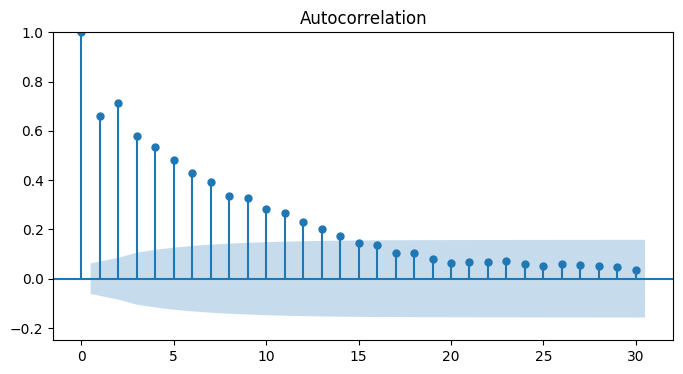

In [16]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_acf(AR2_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)

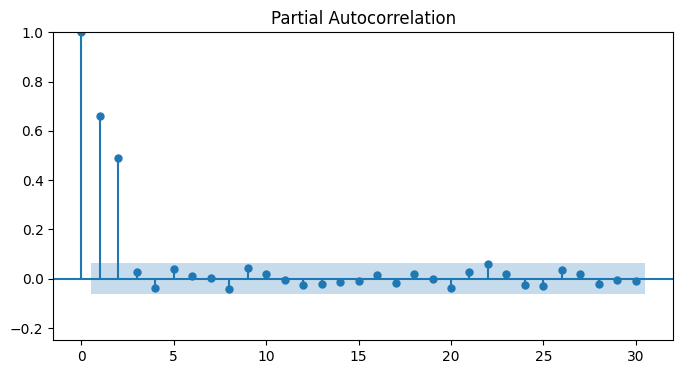

In [17]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_pacf(AR2_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)
plt.show()

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
train = df[:800]
test =df[800:]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR', 2)

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.048235,1.153388,0.591984
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.047119,0.704340,0.271320
804,-0.142412,-0.047287,-0.182079,0.281393


<Axes: >

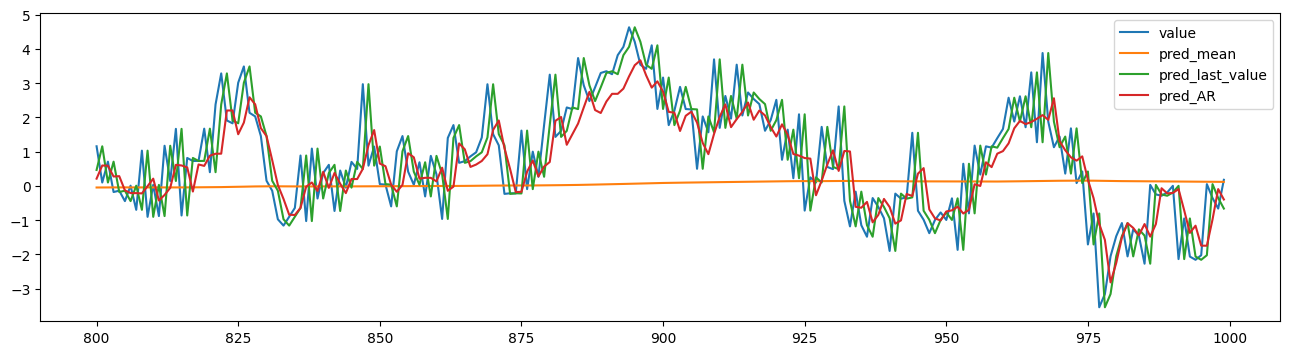

In [72]:
test.plot(figsize=(16,4), layout='constrained')

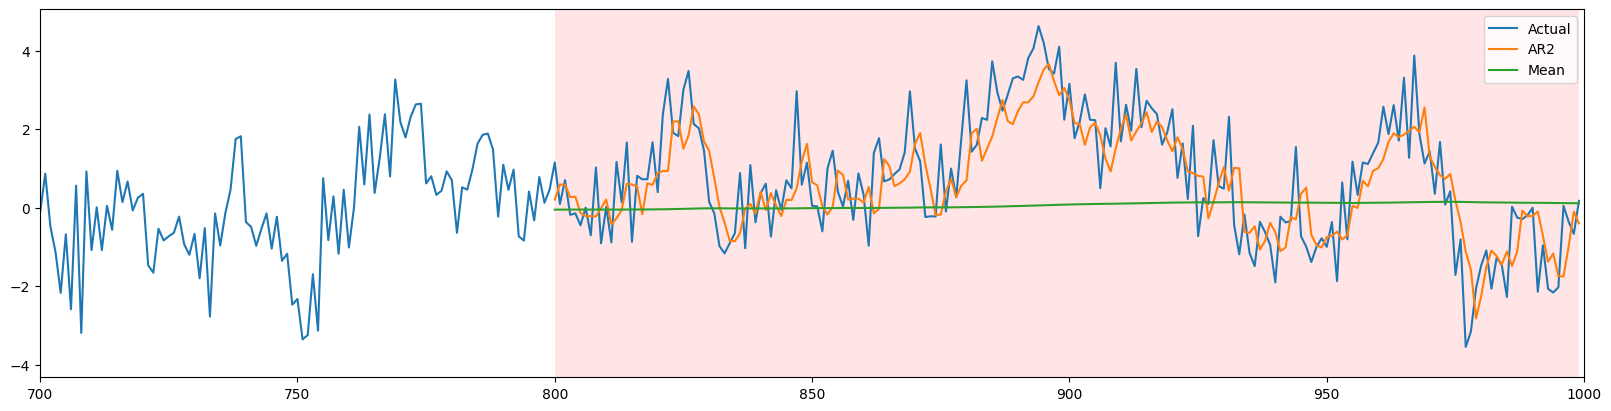

In [73]:
fig, ax = plt.subplots(figsize=(16,4), layout='constrained')

ax.plot(df)
ax.plot(test[['pred_AR', 'pred_mean']])
ax.axvspan(800, 999, facecolor='red', alpha=0.1)
ax.set_xlim(700, 1000)
ax.legend(labels=['Actual', 'AR2', 'Mean'])
plt.show()

In [74]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['AR'] =  mse( torch.FloatTensor( test['pred_AR'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss

{'mean': 3.0856473445892334,
 'last_value': 1.3825808763504028,
 'AR': 0.9329720139503479}

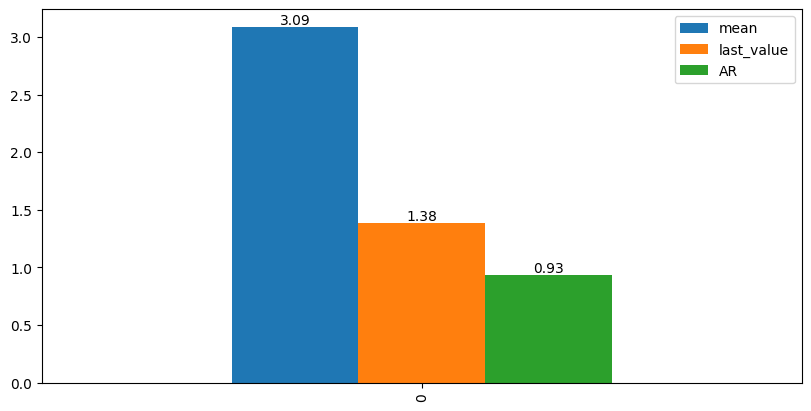

In [75]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
pd.DataFrame([loss]).plot.bar(ax = ax)
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

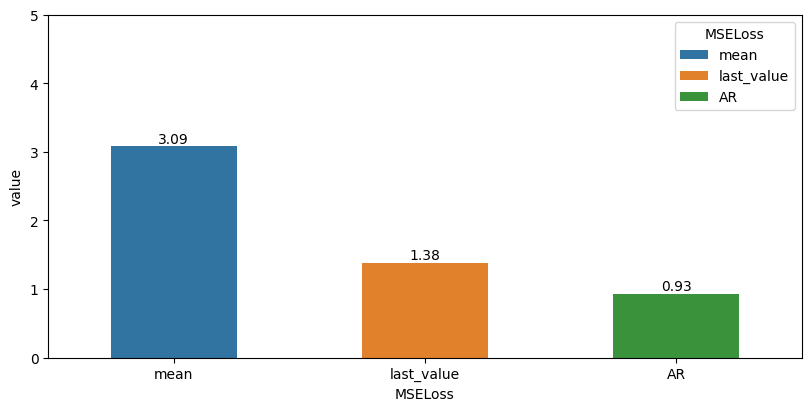

In [76]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([loss]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 5)
ax.set_xlabel('MSELoss')
ax.legend(title='MSELoss')
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [77]:
ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.33, -0.50, -0.07])

AR3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=1000)

<Axes: >

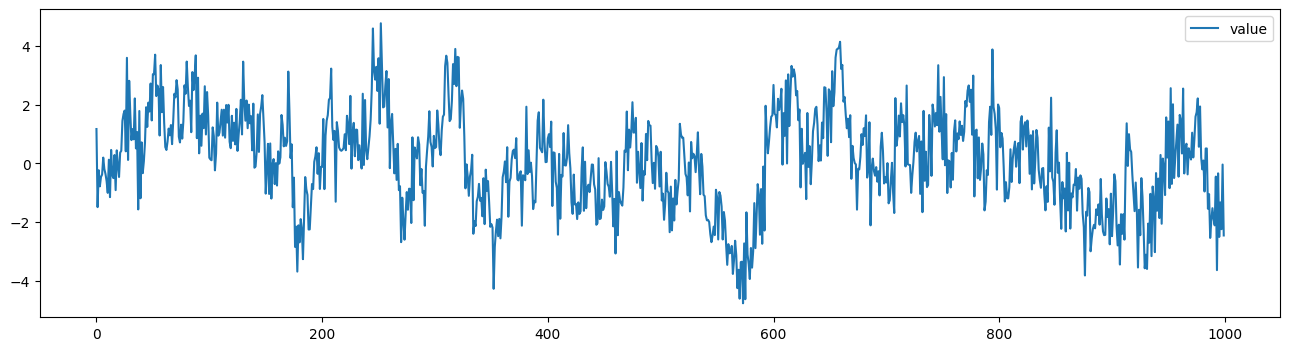

In [78]:
df_3 = pd.DataFrame({'value': AR3_process})
df_3.plot( figsize=(16,4),  layout='constrained')

In [79]:
ADF_result = adfuller(AR3_process)
ADF_result

(-5.9300780706172045,
 2.3921454857211937e-07,
 2,
 997,
 {'1%': -3.4369259442540416,
  '5%': -2.8644432969122833,
  '10%': -2.5683158550174094},
 2736.1688720125444)

(-0.25, 1.0)

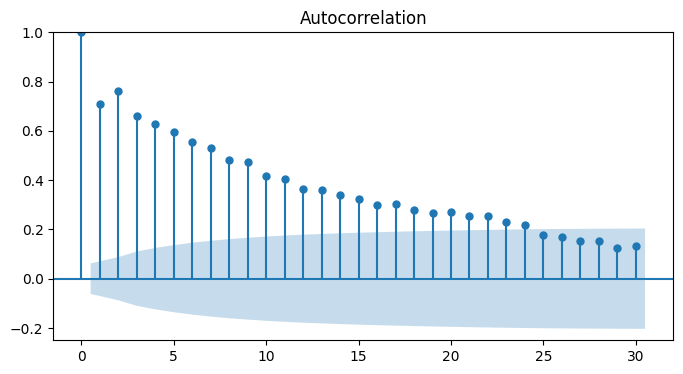

In [80]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_acf(AR3_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)

(-0.25, 1.0)

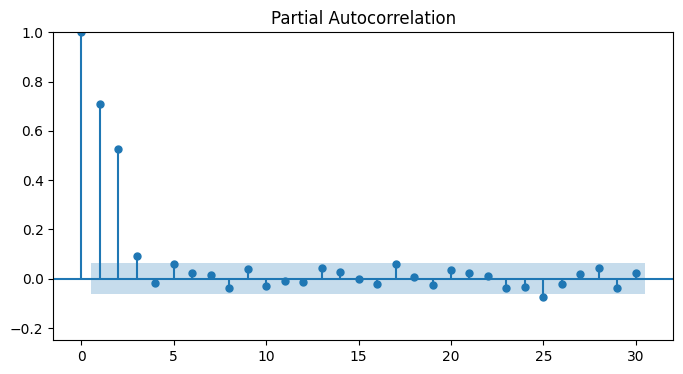

In [81]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_pacf(AR3_process, lags=30, ax=ax)
plt.ylim(-0.25, 1)

In [82]:
train = df_3[:800]
test =df_3[800:]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_3, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_3, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_3, TRAIN_LEN, HORIZON, WINDOW, 'AR', 3)

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.892884,0.303299,2.011172,0.282363
801,0.552166,0.305283,1.892884,1.458567
802,1.041554,0.305591,0.552166,1.273215
803,0.847905,0.306507,1.041554,0.766941
804,-0.121116,0.307181,0.847905,0.810428


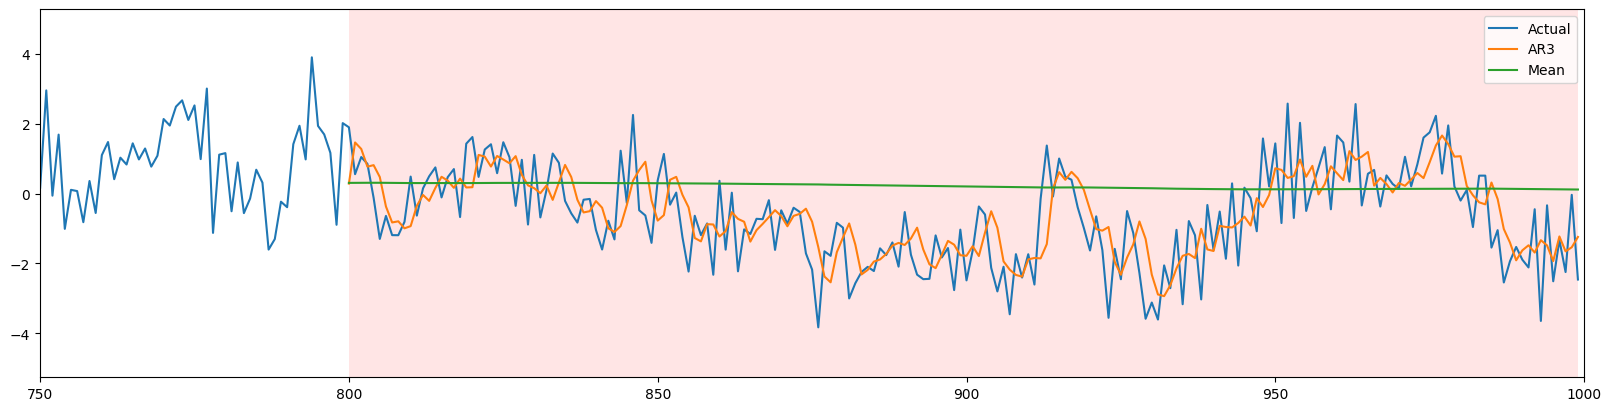

In [94]:
fig, ax = plt.subplots(figsize=(16,4), layout='constrained')

ax.plot(df_3)
ax.plot(test[['pred_AR', 'pred_mean']])
ax.axvspan(800, 999, facecolor='red', alpha=0.1)
ax.set_xlim(750, 1000)
ax.legend(labels=['Actual', 'AR3', 'Mean'])
plt.show()

In [84]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['AR'] =  mse( torch.FloatTensor( test['pred_AR'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss

{'mean': 2.6579372882843018,
 'last_value': 1.802586317062378,
 'AR': 1.019355297088623}

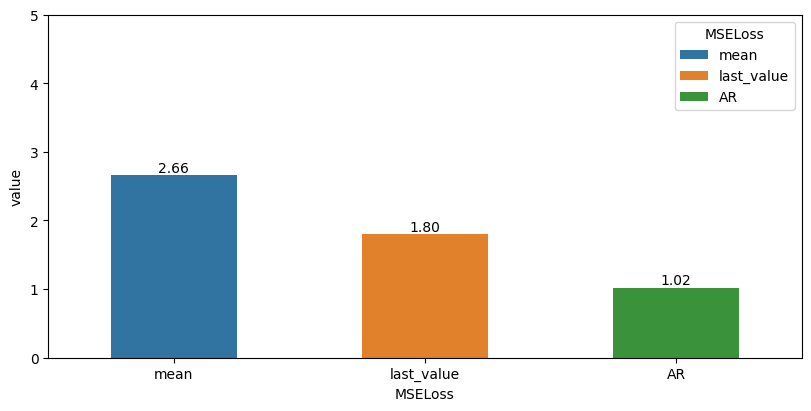

In [85]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([loss]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 5)
ax.set_xlabel('MSELoss')
ax.legend(title='MSELoss')
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)